## フーリエ変換　ハイパスフィルタ

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# bgr -> gray
def bgr2gray(img):
    gray = 0.2126*img[...,2] + 0.7152*img[..., 1] + 0.0722*img[...,0]
    return  gray

# DFT
def dft(img):
    # prepare DFT coefficient
    # 周波数ごとの振幅（係数：coefficient）を格納する配列
    G = np.zeros((L, K, channel), dtype=np.complex)
    
    # prepare processed index corresponding to original image positions
    x = np.tile(np.arange(W), (H, 1))
    y = np.arange(H).repeat(W).reshape(H, -1)
    
    #dft
    for c in range(channel):
        for l in range(L):
            for k in range(K):
                # 画素値からスペクトルを出している
                G[l,k,c] = np.sum(img[...,c]*np.exp(-2j*np.pi*(x*k/K + y*l/L))) / np.sqrt(K*L)
                
    return G

# HPF
def hpf(G, ratio=0.1):
    H, W, _ = G.shape
    
    # transfer positions
    # これ入れ替える必要なくない？入れ替えないでfilterのかけ方だけ変えればいい気がする
    _G = np.zeros_like(G)
    _G[:H//2, :W//2] = G[H//2:, W//2:]
    _G[:H//2, W//2:] = G[H//2:, :W//2]
    _G[H//2:, :W//2] = G[:H//2, W//2:]
    _G[H//2:, W//2:] = G[:H//2, :W//2]
    
    # get dixtance from center(H/2, W/2)
    x = np.tile(np.arange(W), (H,1))
    y = np.arange(H).repeat(W).reshape(H, -1)
    
    # make filter
    _x = x - W//2
    _y = y - H//2
    r = np.sqrt(_x**2+_y**2)
    mask = np.ones((H, W), dtype=np.float32)
    # W//2*ratioを基準にしていいんだろうか
    mask[r < (W//2*ratio)] = 0
    
    mask = np.repeat(mask, channel).reshape(H, W, channel)
    
    # filtering
    _G *= mask
    
    # reverse original positions
    G[:H//2, :W//2] = _G[H//2:, W//2:]
    G[:H//2, W//2:] = _G[H//2:, :W//2]
    G[H//2:, :W//2] = _G[:H//2, W//2:]
    G[H//2:, W//2:] = _G[:H//2, :W//2]
    
    return G

# IDFT
def idft(G):
    # prepare out image
    H, W, _ = G.shape
    out = np.zeros((H, W, channel), dtype=np.float32)
    
    # prepare processed index corresponding to original positions
    x = np.tile(np.arange(W), (H, 1))
    y = np.arange(H).repeat(W).reshape(H, -1)
    
    # idft
    for  c in range(channel):
        for l in range(H):
            for k in range(W):
                # スペクトルから画素値を出している
                out[l, k, c] = np.abs(np.sum(G[..., c]*np.exp(2j*np.pi*(x*k/W + y*l/H)))) / np.sqrt(H*W)
                
    # clipping
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    
    return out


    


True

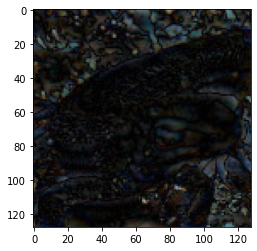

In [10]:
K, L = 128, 128
channel = 3

img = cv2.imread('../imori.jpg').astype(np.float32)
H, W, C = img.shape  # 128, 128, 3

gray = bgr2gray(img)

# なんでグレースケールにしたのにimg使うのか
# grayを使うとただの縞模様になる
G = dft(img)
HFP = hpf(G, ratio=0.1)
out = idft(HFP)

plt.imshow(out, cmap='gray')
cv2.imwrite('out34.jpg', out)


In [ ]:
x = np.linapace(0,255)
img[:, ] = np.sin(2*np.pi*x)